# M3 - Time Series Assignment - Mada

Using the data in the file Construction TimeSeries Datav2.csv, decompose the data and create a forecasting model.  For each of the two data series, compute the squared error for the model relative to the original data series for each month, and cumulatively as well.  More specifically, compute a pandas column named R2X, that shows the error of your model relative to the original data series, where x is replaced by either Public or Private for the respective analyses.  Also, compute a pandas column named r2ErrorX that shows R2 relative to (divided by) the original data series.

In [129]:
# Code below sets up libraries and reads in the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import os

os.chdir('c:\\users\shann\desktop\cbadatasets')

# Extract Necessary Data

df = pd.read_csv('ConstructionTimeSeriesDataV2.csv')

dates=df['Month-Year']
privatesales=df['Private Construction']
publicsales=df['Public Construction']


del(df)    # tidy-up


In [145]:
# Core functions that takes in data and creates a forecast model

# This is simply the alogrithm from the lecture (method 2) re-cast as a function
# Allows for trial and error of ideal window
# Inputs -- dates, data, window and title for the graph
# Window is variablized; Date information for index is hard coded
# Only end graph is presented -- added title

def sqErr(row):
    return (row[1] - row[2])**2

def forecastHousing (dates,Construction,window,title):  
    
    X = pd.DataFrame({'MonthYear':dates, 'Construction':Construction})  # adjusted to Month Year
    X['MovAvg'] = np.NaN
    X['sqErr'] = np.NaN
    X.index = pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002, month=1, day=31), periods = len(X['Construction']))
    
    # Compute Moving Average and Squared Error
    
    for i in range(window+1,len(X)):
        X.loc[X.index[i],'MovAvg'] = sum(X.iloc[range(i-window-1,i)]['Construction'])/float(window)
    X['sqErr'] = X.apply(sqErr,axis='columns')
    X.dropna(how='any',inplace=True)
    
    X['R1'] = X['Construction'] - X['MovAvg']
    X['R1Error'] = abs((X['Construction'] - X['R1'])/X['Construction'])
    X.style.format({
        'MovAvg': '{:.1f}'.format,
        'sqErr': '{:,.1f}'.format    
    })
    
    # Compute Correlation
    
    maxCorr = 0.0
    period = np.NaN
    for i in range(1,37):
        corr = X['R1'].autocorr(lag=i)  
        if corr > maxCorr:
            maxCorr = corr
            period = i

    # Compute Cycles        
            
    cycleLen = period   # see prior cell for computation of cyclicality period
    avg = []            # a list to store the average demand for each period of the cycle
    numCycles = int(len(X)/cycleLen + 0.5)
    for j in range(cycleLen):
        if j + (numCycles-1) * cycleLen < len(X):
            d = X.iloc[range(j,j + (numCycles-1) * cycleLen+1,cycleLen)]['R1']
            avg.append(sum(d)/len(d))
        else:
            d = X.iloc[range(j,j + (numCycles-2) * cycleLen+1,cycleLen)]['R1']
            avg.append(sum(d)/len(d))
    X['C'] = np.NaN
    for i in range(len(X)):
        X.loc[X.index[i], 'C'] = avg[i % cycleLen]           
            
    # Compute Errors and Fit
    
    X['R2X'] = X['R1'] - X['C']
    X['R2ErrorX'] = abs(X['R2X']/X['Construction'])
    X['fit'] = X['MovAvg'] + X['C']   
    
    
    # Graph the Forecasting Model
            
    fig,ax = plt.subplots()
    ax.title.set_text(title)
    ax.plot(X['Construction'],label='Construction')
    ax.plot(X['fit'],label='Fit')
    ax.plot(X['R2X'],label='Residual')
    # ax.set_xlabel('Year')    # year is self evident, removed it
    ax.set_ylabel('Units of Demand')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    fig.legend() 

    return(X)
    

,MonthYear,Construction,MovAvg,sqErr,R1,R1Error,C,R2X,R2ErrorX,fit
2003-03-31,Mar-03,14510,18596.000000,1.669540e+07,-4086.000000,1.281599,-4279.062937,193.062937,0.013306,14316.937063
2003-04-30,Apr-03,16444,18616.538462,4.719923e+06,-2172.538462,1.132117,-2385.692308,213.153846,0.012962,16230.846154
2003-05-31,May-03,18187,18795.846154,3.706936e+05,-608.846154,1.033477,-561.132867,-47.713287,0.002623,18234.713287
2003-06-30,Jun-03,20301,19088.230769,1.470809e+06,1212.769231,0.940261,1837.503497,-624.734266,0.030774,20925.734266
2003-07-31,Jul-03,20755,19402.076923,1.830401e+06,1352.923077,0.934815,2017.062937,-664.139860,0.031999,21419.139860
2003-08-31,Aug-03,21957,19585.153846,5.625654e+06,2371.846154,0.891978,3040.979021,-669.132867,0.030475,22626.132867
2003-09-30,Sep-03,22075,19783.307692,5.251854e+06,2291.692308,0.896186,2357.874126,-66.181818,0.002998,22141.181818
2003-10-31,Oct-03,20321,19914.538462,1.652110e+05,406.461538,0.979998,103.713287,302.748252,0.014898,20018.251748
2003-11-30,Nov-03,17801,19823.307692,4.089728e+06,-2022.307692,1.113606,-1989.083916,-33.223776,0.001866,17834.223776
2003-12-31,Dec-03,15466,19547.615385,1.665958e+07,-4081.615385,1.263909,-4800.720280,719.104895,0.046496,14746.895105


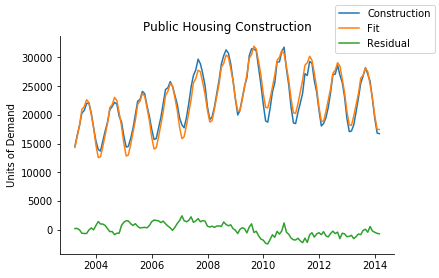

In [146]:
forecastHousing(dates,publicsales,13,"Public Housing Construction")




 

,MonthYear,Construction,MovAvg,sqErr,R1,R1Error,C,R2X,R2ErrorX,fit
2002-10-31,Oct-02,56023,59605.125,1.283162e+07,-3582.125,1.063940,-1934.170455,-1647.954545,0.029416,57670.954545
2002-11-30,Nov-02,53552,60948.875,5.471376e+07,-7396.875,1.138125,-7636.000000,239.125000,0.004465,53312.875000
2002-12-31,Dec-02,48023,62083.500,1.976977e+08,-14060.500,1.292787,-14404.420455,343.920455,0.007162,47679.079545
2003-01-31,Jan-03,45473,61911.875,2.702366e+08,-16438.875,1.361508,-19537.909091,3099.034091,0.068151,42373.965909
2003-02-28,Feb-03,44620,60935.625,2.661996e+08,-16315.625,1.365657,-18965.738636,2650.113636,0.059393,41969.886364
2003-03-31,Mar-03,49996,59637.000,9.294888e+07,-9641.000,1.192835,-11952.034091,2311.034091,0.046224,47684.965909
2003-04-30,Apr-03,53195,58661.375,2.988126e+07,-5466.375,1.102761,-8094.193182,2627.818182,0.049400,50567.181818
2003-05-31,May-03,56286,57999.000,2.934369e+06,-1713.000,1.030434,-4046.909091,2333.909091,0.041465,53952.090909
2003-06-30,Jun-03,60076,57790.625,5.222939e+06,2285.375,0.961959,-796.500000,3081.875000,0.051300,56994.125000
2003-07-31,Jul-03,62216,58405.500,1.451991e+07,3810.500,0.938754,146.670455,3663.829545,0.058889,58552.170455


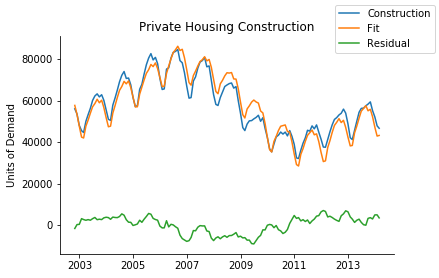

In [147]:
forecastHousing(dates,privatesales,8,"Private Housing Construction")
